# 11-sat_image_analysis_script
### Objective: Computing with unavailable dates by skipping data_checks.

This notebook is a simplified version of script 17-sat_image_analysis.py (Updated up until Sept 10 2024).
The purpose of this notebook is to allow the user to __skip the missing dates analysis and interpolation in order to use only real available data__. [Developed for project Volvo because in Medellin most months had cloud coverage].

## Import libraries

In [1]:
accesibilidad_urbana = '../../'

In [2]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:24: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(


## Config notebook

In [3]:
projection_crs = "EPSG:32618"

In [4]:
# Set raster spectral bands and analysis equation
band_name_dict = {'nir':[False], #If GSD(resolution) of band is different, set True.
                  'red':[False], #If GSD(resolution) of band is different, set True.
                  'eq':['(nir-red)/(nir+red)']}

# Set analysis type name
index_analysis = 'ndvi'

# Set directory to save analysed rasters
tmp_dir = accesibilidad_urbana + f'data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [8,11] # This notebook uses only two resolutions. First res is big_res, used to shape the city. Second res is output_res.

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2018-01-01'
end_date = '2024-09-18'

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
sat_query = {"eo:cloud_cover": {"lt": 15}}

# Del rasters after processing.
del_data = False # True

# Save?
local_save = True #------ Set True if saving to local

# city can be substituted by place name (presa_laboca / presa_cerroprieto / presa_elcuchillo) if not loading from database.
city = 'Medellin'

## Folder existance check

In [5]:
###############################
# Create folder to store city skip_list
folder_dir = accesibilidad_urbana + f'/data/processed/{index_analysis}_skip_city/'
if os.path.exists(folder_dir) == False:
    os.mkdir(folder_dir)
    
# Create city skip_list
df_skip_dir = accesibilidad_urbana + f'/data/processed/{index_analysis}_skip_city/skip_list.csv'
if os.path.exists(df_skip_dir) == False: # Or folder, will return true or false
    df_skip = pd.DataFrame(columns=['city','missing_months','unable_to_download'])
    df_skip.to_csv(df_skip_dir, index=False)
else:
    df_skip = pd.read_csv(df_skip_dir)

# Read current cities to skip
skip_list = list(df_skip.city.unique())

# Create folder to store raster analysis
if os.path.exists(tmp_dir) == False:
    os.mkdir(tmp_dir)

### DEV NOTEBOOK, NOT USING. LOADS ALL CITIES AND ALREADY PROCESSED CITIES LIST
#gdf_mun = aup.gdf_from_db('metro_gdf_2020', 'metropolis')
#gdf_mun = gdf_mun.sort_values(by='city')

# prevent cities being analyzed several times in case of a crash
#aup.log('Downloading preprocessed data')
processed_city_list = []
#try:
#    query = f"SELECT city FROM raster_analysis.{index_analysis}_analysis_hex"
#    processed_city_list = aup.df_from_query(query)
#    processed_city_list = list(processed_city_list.city.unique())
#except:
#    pass
### DEV NOTEBOOK, NOT USING.

## Main function starts here

In [6]:
# Load existing database hexgrid
load = False
# Load local area of interest and create hexgrid
create = True

### 01 - Load or create hex area of interest

#### 01a - Load (From Script 17)

In [7]:
if load:
    ###############################
    ### Create city area of interest with biggest hexs
    big_res = min(res)
    schema_hex = 'hexgrid'
    table_hex = f'hexgrid_{big_res}_city_2020'
    
    # Download hexagons with type=urban
    type = 'urban'
    query = f"SELECT hex_id_{big_res},geometry FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}\' AND \"type\" = '{type}\'"
    hex_urban = aup.gdf_from_query(query, geometry_col='geometry')
    
    # Download hexagons with type=rural within 500m buffer
    poly = hex_urban.to_crs("EPSG:6372").buffer(500).reset_index()
    poly = poly.to_crs("EPSG:4326")
    poly_wkt = poly.dissolve().geometry.to_wkt()[0]
    type = 'rural'
    query = f"SELECT hex_id_{big_res},geometry FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}\' AND \"type\" = '{type}\' AND (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\'))"
    hex_rural = aup.gdf_from_query(query, geometry_col='geometry')
    
    # Concatenate urban and rural hex
    hex_city = pd.concat([hex_urban, hex_rural])
    
    print(f'Downloaded {len(hex_city)} hexagon features')

#### 01b - Create

In [8]:
if create:
    # Load area of interest (aoi)
    gdf = gpd.read_file(accesibilidad_urbana + 'data/external/temporal_todocker/colombia/medellin_urban_gcs.geojson')
    
    # Create 500m buffer around aoi
    poly = gdf.to_crs(projection_crs).buffer(500).reset_index()
    poly = poly.to_crs("EPSG:4326")
    poly.rename(columns={0:'geometry'},inplace=True)
    poly.set_geometry('geometry',inplace=True)

    # Create hexgrid for poly
    big_res = min(res)
    hex_city = aup.create_hexgrid(poly,big_res)

    print(f'Downloaded {len(hex_city)} hexagon features')

Downloaded 334 hexagon features


EPSG:4326
(334, 2)
['hex_id_8', 'geometry']


<Axes: >

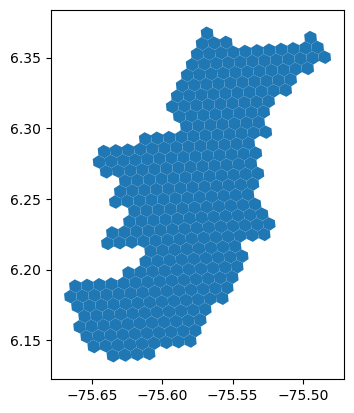

In [9]:
# Show loaded or created hex_city
print(hex_city.crs)
print(hex_city.shape)
print(list(hex_city.columns))
hex_city.plot()

### 02 - Download and process rasters

### __02 Before developing__ - Function stops due to amount of unavailable data.

In [11]:
### Download and process rasters
df_len = aup.download_raster_from_pc(hex_city, index_analysis, city, freq, start_date, end_date, 
                                     tmp_dir, band_name_dict, query = sat_query, satellite = satellite)

/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


AvailableData: Missing more than 50 percent of data points

##### __Without intervention, error:__ Missing more than 50 percent of data points [From 2018 to sep 2024, 81% are missing]
##### __Location of error raise:__ Function available_data_check.

### __02 Developing__ - Exploring function aup.download_raster_from_pc

* aup.download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a")

In [17]:
# Args data for function download_raster_from_pc
gdf = hex_city.copy()
query = sat_query

In [18]:
# Create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs(projection_crs).buffer(500) ########################## EDIT TO BE INCORPORATED
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry

# Extract coordinates from polygon as DataFrame
coord_val = poly.bounds
# Get coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Set the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# Create time of interest (Creates a list for all to-be-analysed-months with structure [start_day/end_day,(...)])
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# Gather items for time and area of interest (Creates of list of available image items)
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

date_list = aup.available_datasets(items, satellite) # (Creates a list of dates where images are available)

# Create dictionary from links (assets_hrefs is a dict. of dates and links with structure {available_date:{band_n:[link]}})
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
print('Created dictionary from items')

Extracting bounding coordinates from hexagons
Defining time of interest
Gathering items for time and area of interest


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Fetched 121 items
Created dictionary from items


In [19]:
########################## EDIT TO BE INCORPORATED
compute_unavailable_dates = False

In [20]:
# analyze available data according to raster properties (Creates df_len)
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)

########################## EDIT TO BE INCORPORATED
if compute_unavailable_dates:
    aup.available_data_check(df_len, missing_months) # test for missing months, raises errors.
########################## EDIT TO BE INCORPORATED

# Show
print(missing_months)
print(df_len.shape)
df_len.head(2)

61
(81, 3)


,year,month,data_id
0,2018,1,0
1,2018,2,0


In [63]:
# creates raster and analyzes percentage of missing data points
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
pct_missing = round(missing_months/len(df_len),2)*100

########################## EDIT TO BE INCORPORATED
if compute_unavailable_dates and pct_missing >= 50:
    # if more than 50% of data is missing, raise error and print message
    raise AvailableData('Missing more than 50 percent of data points')
########################## EDIT TO BE INCORPORATED

# Show
print(missing_months)
print(f"{pct_missing}%")
print(df_len.shape)
df_len.head(2)

66
81.0%
(81, 3)


,year,month,data_id
0,2018,1,0
1,2018,2,0


In [64]:
# raster cropping with bounding box from earlier 
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
print('Created bounding box for raster cropping')

# create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:6372").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

Created bounding box for raster cropping


In [68]:
# raster creation
print('Starting raster creation for specified time')
# download raster data by month
#create_raster_by_month(df_len, index_analysis, city, tmp_dir, 
#                       band_name_dict, date_list, gdf_raster_test, gdf_bb, 
#                       aoi, sat, query={}, time_exc_limit=1500)

df_len = aup.create_raster_by_month(df_len, index_analysis, city, tmp_dir,
                                    band_name_dict, date_list, gdf_raster_test,
                                    gdf_bb, area_of_interest, satellite, query=query)
print('Finished raster creation')

Starting raster creation for specified time


  0%|                                                                                                                                                                                               | 0/81 [00:00<?, ?it/s]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
 10%|██████████████████                                                                                                                                                                     | 8/81 [02:09<19:43, 16.22s/it]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
 16%|█████████████████████████████▏                                                                                                                                                        | 13/81 [05:41<32:23, 28.57s/it]/opt/conda/envs/gds/l

AvailableData: Missing more than 50 percent of data points

##### __Without intervention, error:__ Missing more than 50 percent of data points
##### __Location of error raise:__ Function available_data_check __INSIDE create_raster_by_month__.

### __02 Developing__ - Redefining function aup.create_raster_by_month

In [72]:
def edited_create_raster_by_month(df_len, index_analysis, city, tmp_dir, 
                                  band_name_dict, date_list, gdf_raster_test, gdf_bb, 
                                  aoi, sat, query={}, time_exc_limit=1500, compute_unavailable_dates=True):
    """
    The function is used to create a raster for each month of the year within the time range
    The function takes in a dataframe with the length of years and months, an index analysis, city name, 
    temporary directory path (tmp_dir), band name list (band_name_list), date list (date_list), 
    geodataframe bounding box(gdf_bb) and area of interest(aoi). 
    the function also performs raster analysis for each row of the DataFrame, downloads and processes 
    the raster data, calculates an index, crops the raster, performs interpolation, and 
    saves the processed rasters and corresponding metadata in the specified directory. 

    Arguments:
        df_len (pandas.DataFrame): Summary dataframe indicating available raster data for each month
        index_analysis (str): Define the index analysis
        city (str): Save the raster files based on the city name
        tmp_dir (str): Save the raster files in a temporary directory
        band_name_list (list): Define the bands that will be used in the analysis
        date_list (list): Define the dates that are used to download the images
        gdf_bb (geopandas.GeoDataFrame): Crop the raster to a specific area of interest
        aoi (str): Define the area of interest
        sat (str): Define the satellite used to gather data
        time_exc_limit (int): Set the time limit for downloading a raster
        compute_unavailable_dates (bool): Whether or not to consider unavailable dates (And raise errors when too many unavailable)

    Returns:
        df_len (pandas.DataFrame): Summary dataframe indicating available raster data for each month.  
    """
    df_len['able_to_download'] = np.nan
    band_name_list = list(band_name_dict.keys())[:-1]

    print('\n Starting raster analysis')

    # check if file exists, for example in case of code crash
    df_file_dir = tmp_dir+index_analysis+f'_{city}_dataframe.csv'
    if os.path.exists(df_file_dir) == False: # Or folder, will return true or false
        df_len.to_csv(df_file_dir, index=False)
    # create folder to store temporary raster files by iteration
    tmp_raster_dir = tmp_dir+'temporary_files/'
    if os.path.exists(tmp_raster_dir) == False: # Or folder, will return true or false
        os.mkdir(tmp_raster_dir)

    for i in tqdm(range(len(df_len)), position=0, leave=True):
        
        df_raster = pd.read_csv(df_file_dir, index_col=False)

        # binary id - checks if month could be processed
        checker = 0

        if df_raster.iloc[i].data_id==0:
            continue
            
        # gather month and year from df to save raster
        month_ = df_raster.loc[df_raster.index==i].month.values[0]
        year_ = df_raster.loc[df_raster.index==i].year.values[0]
        
        if f'{city}_{index_analysis}_{month_}_{year_}.tif' in os.listdir(tmp_dir):
            continue
        
        print(f'\n Starting new analysis for {month_}/{year_}')
        
        # gather links for raster images
        sample_date = datetime(year_, month_, 1)
        first_day = sample_date + relativedelta(day=1)
        last_day = sample_date + relativedelta(day=31)

        # creates time range for a specific month
        time_of_interest = [f"{year_}-{month_:02d}-{first_day.day:02d}/{year_}"+
                            f"-{month_:02d}-{last_day.day:02d}"]
    
        # create dataframe
        #df_links = pd.DataFrame.from_dict(assets_hrefs, 
        #                                orient='Index').reset_index().rename(columns={'index':'date'})

        # dates according to cloud coverage
        date_order = [True if (d.month == month_) and (d.year == year_) else False for d in date_list]
        date_array = np.array(date_list)
        date_filter = np.array(date_order)
        dates_ordered = date_array[date_filter]
        
        # mosaic raster iterations (while loop tries 5 times to process all available rasters (dates) in a month)
        iter_count = 1
        # create skip date list used to analyze null values in raster
        skip_date_list = []
        
        while iter_count <= 5:
            # gather links for the date range from planetary computer
            items = aup.gather_items(time_of_interest, aoi, query=query, satellite=sat)
            
            # gather links from dates that are within date_list
            assets_hrefs = aup.link_dict(band_name_list, items, date_list)

            #for data_link in range(len(df_links)):
            for data_link in range(len(dates_ordered)):
                 
                # Skip date if in skip_date_list
                if dates_ordered[data_link] in skip_date_list:
                    print(f'Skipped {dates_ordered[data_link]} - iteration:{iter_count} because it did not pass null test.')
                    continue
                 
                # log(data_link)
                print(f'Skip list:{skip_date_list}')
                print(dates_ordered[data_link])
                print(f'Mosaic date {dates_ordered[data_link].day}'+
                            f'/{dates_ordered[data_link].month}'+
                            f'/{dates_ordered[data_link].year} - iteration:{iter_count}')
                
                # check if date contains null values within study area
                #if df_links.iloc[data_link]['date'] in skip_date_list:

                try:
                    #links_band_1 = df_links.iloc[data_link][list(band_name_dict.keys())[0]]
                    #links_band_2 = df_links.iloc[data_link][list(band_name_dict.keys())[1]]
                    bands_links = assets_hrefs[dates_ordered[data_link]]

                    rasters_arrays = func_timeout(time_exc_limit, aup.mosaic_process_v2,
                                                                                args=(bands_links,
                                                                                      band_name_dict, gdf_bb, tmp_raster_dir))
                    out_meta = rasters_arrays[list(rasters_arrays.keys())[0]][2]

                    # calculate raster index
                    raster_idx = aup.calculate_raster_index(band_name_dict, rasters_arrays)
                    print(f'Calculated {index_analysis}')
                    del rasters_arrays

                    print(f'Starting interpolation')

                    raster_idx[raster_idx == 0 ] = np.nan # change zero values to nan
                    # only for temperature
                    raster_idx[raster_idx == -124.25 ] = np.nan # change zero values to nan
                    raster_idx = raster_idx.astype('float32') # change data type to float32 to avoid fillnodata error

                    print(f'Interpolating {np.isnan(raster_idx).sum()} nan values')
                    raster_fill = fillnodata(raster_idx, mask=~np.isnan(raster_idx),
                                        max_search_distance=50, smoothing_iterations=0)
                    print(f'Finished interpolation to fill na - {np.isnan(raster_fill).sum()} nan')

                    with rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif",'w', **out_meta) as dest:
                            dest.write(raster_fill)

                            dest.close()

                    print('Starting null test')

                    raster_file = rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif")

                    gdf_raster_test = gdf_raster_test.to_crs(raster_file.crs)

                    try:
                        # test for nan values within study area
                        aup.raster_nan_test(gdf_raster_test,raster_file)

                        print('Passed null test')
                        
                        # save raster to processing database
                        with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
                            dest.write(raster_fill)

                            dest.close()
                        print(f'Finished saving {index_analysis} raster')

                        checker = 1
                        iter_count = 6
                        aup.delete_files_from_folder(tmp_raster_dir)
                        break
                    except:
                        print('Failed null test')
                        skip_date_list.append(dates_ordered[data_link])
                        aup.delete_files_from_folder(tmp_raster_dir)

                except:
                    print(f'Error in iteration {iter_count}')
                    aup.delete_files_from_folder(tmp_raster_dir)
                    continue
            iter_count = iter_count + 1
                
        if checker==0:
            df_raster.loc[df_raster.index==i,'data_id']=0
            df_raster.loc[df_raster.index==i,'able_to_download']=0
            df_raster.to_csv(df_file_dir, index=False)
            ########################## EDIT TO BE INCORPORATED
            if compute_unavailable_dates:
            ########################## EDIT TO BE INCORPORATED
                aup.available_data_check(df_raster, len(df_raster.loc[df_raster.data_id==0])) # test for missing months
            continue

    df_len = pd.read_csv(df_file_dir, index_col=False)

    return df_len

In [75]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
df_len = edited_create_raster_by_month(df_len, index_analysis, city, tmp_dir,
                                       band_name_dict, date_list, gdf_raster_test,
                                       gdf_bb, area_of_interest, satellite, query=query,
                                       compute_unavailable_dates=compute_unavailable_dates)
print('Finished raster creation')


 Starting raster analysis


  0%|                                                                                                                                                                                               | 0/81 [00:00<?, ?it/s]


 Starting new analysis for 7/2021


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Skip list:[]
2021-07-20
Mosaic date 20/7/2021 - iteration:1
Error in iteration 1
Skip list:[]
2021-07-20
Mosaic date 20/7/2021 - iteration:2
Error in iteration 2
Skip list:[]
2021-07-20
Mosaic date 20/7/2021 - iteration:3
Error in iteration 3
Skip list:[]
2021-07-20
Mosaic date 20/7/2021 - iteration:4
Error in iteration 4


 53%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 43/81 [00:16<00:14,  2.55it/s]

Skip list:[]
2021-07-20
Mosaic date 20/7/2021 - iteration:5
Error in iteration 5

 Starting new analysis for 1/2022


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Skip list:[]
2022-01-31
Mosaic date 31/1/2022 - iteration:1
Error in iteration 1
Skip list:[]
2022-01-31
Mosaic date 31/1/2022 - iteration:2
Error in iteration 2
Skip list:[]
2022-01-31
Mosaic date 31/1/2022 - iteration:3
Error in iteration 3
Skip list:[]
2022-01-31
Mosaic date 31/1/2022 - iteration:4
Error in iteration 4


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 49/81 [00:21<00:14,  2.15it/s]

Skip list:[]
2022-01-31
Mosaic date 31/1/2022 - iteration:5
Error in iteration 5

 Starting new analysis for 7/2023


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Skip list:[]
2023-07-20
Mosaic date 20/7/2023 - iteration:1
Error in iteration 1
Skip list:[]
2023-07-20
Mosaic date 20/7/2023 - iteration:2
Error in iteration 2
Skip list:[]
2023-07-20
Mosaic date 20/7/2023 - iteration:3
Error in iteration 3
Skip list:[]
2023-07-20
Mosaic date 20/7/2023 - iteration:4
Error in iteration 4


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 67/81 [00:45<00:11,  1.22it/s]

Skip list:[]
2023-07-20
Mosaic date 20/7/2023 - iteration:5
Error in iteration 5

 Starting new analysis for 1/2024


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Skip list:[]
2024-01-06
Mosaic date 6/1/2024 - iteration:1
Error in iteration 1
Skip list:[]
2024-01-06
Mosaic date 6/1/2024 - iteration:2
Error in iteration 2
Skip list:[]
2024-01-06
Mosaic date 6/1/2024 - iteration:3
Error in iteration 3
Skip list:[]
2024-01-06
Mosaic date 6/1/2024 - iteration:4
Error in iteration 4


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 73/81 [00:51<00:06,  1.16it/s]

Skip list:[]
2024-01-06
Mosaic date 6/1/2024 - iteration:5
Error in iteration 5

 Starting new analysis for 2/2024


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Skip list:[]
2024-02-15
Mosaic date 15/2/2024 - iteration:1
Error in iteration 1
Skip list:[]
2024-02-15
Mosaic date 15/2/2024 - iteration:2
Error in iteration 2
Skip list:[]
2024-02-15
Mosaic date 15/2/2024 - iteration:3
Error in iteration 3
Skip list:[]
2024-02-15
Mosaic date 15/2/2024 - iteration:4
Error in iteration 4


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 74/81 [01:05<00:09,  1.35s/it]

Skip list:[]
2024-02-15
Mosaic date 15/2/2024 - iteration:5
Error in iteration 5

 Starting new analysis for 6/2024


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Skip list:[]
2024-06-01
Mosaic date 1/6/2024 - iteration:1
Error in iteration 1
Skip list:[]
2024-06-01
Mosaic date 1/6/2024 - iteration:2
Error in iteration 2
Skip list:[]
2024-06-01
Mosaic date 1/6/2024 - iteration:3
Error in iteration 3
Skip list:[]
2024-06-01
Mosaic date 1/6/2024 - iteration:4
Error in iteration 4


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 78/81 [01:46<00:08,  2.92s/it]

Skip list:[]
2024-06-01
Mosaic date 1/6/2024 - iteration:5
Error in iteration 5

 Starting new analysis for 8/2024


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Skip list:[]
2024-08-15
Mosaic date 15/8/2024 - iteration:1
Error in iteration 1
Skip list:[]
2024-08-15
Mosaic date 15/8/2024 - iteration:2
Error in iteration 2
Skip list:[]
2024-08-15
Mosaic date 15/8/2024 - iteration:3
Error in iteration 3
Skip list:[]
2024-08-15
Mosaic date 15/8/2024 - iteration:4
Error in iteration 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [02:05<00:00,  1.55s/it]

Skip list:[]
2024-08-15
Mosaic date 15/8/2024 - iteration:5
Error in iteration 5
Finished raster creation


In [77]:
df_len.head(40)

,year,month,data_id,able_to_download
0,2018,1,0,NaN
1,2018,2,0,NaN
2,2018,3,0,NaN
3,2018,4,0,NaN
4,2018,5,0,NaN
5,2018,6,0,NaN
6,2018,7,0,NaN
7,2018,8,1,NaN
8,2018,9,0,NaN
9,2018,10,0,NaN


In [79]:
df_len.tail(41)

,year,month,data_id,able_to_download
40,2021,5,0,NaN
41,2021,6,0,NaN
42,2021,7,0,0.0
43,2021,8,0,NaN
44,2021,9,0,NaN
45,2021,10,0,NaN
46,2021,11,0,NaN
47,2021,12,0,NaN
48,2022,1,0,0.0
49,2022,2,0,NaN


### __02 After developing__ - 'projection_crs' and 'compute_unavailable_dates' args addition.

In [10]:
### Download and process rasters
df_len = aup.download_raster_from_pc(hex_city, index_analysis, city, freq, start_date, end_date, 
                                     tmp_dir, band_name_dict, query = sat_query, satellite = satellite,
                                     projection_crs=projection_crs, compute_unavailable_dates=False)

/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
  0%|                                                                                                                                                                                                  | 0/81 [00:00<?, ?it/s]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
 33%|█████████████████████████████████████████████████████████████▋                                                                                                                           | 27/81 [01:19<02:38,  2.93s/it]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search

### __03 Load or create output hexgrids__

#### 03a - Load (From Script 17)

In [11]:
if load:
    # Create res_list
    res_list=[]
    for r in range(res[0],res[-1]+1):
        res_list.append(r)
    
    # Load hexgrids
    hex_gdf = hex_city.copy()
    hex_gdf.rename(columns={f'hex_id_{big_res}':'hex_id'}, inplace=True)
    hex_gdf['res'] = big_res
    
    aup.log(f'Loaded hexgrid res {big_res}')
    
    for r in res_list:
        # biggest resolution already loaded
        if r == big_res:
            continue
        
        # Load hexgrid
        table_hex = f'hexgrid_{r}_city_2020'
        query = f"SELECT hex_id_{r},geometry FROM {schema_hex}.{table_hex} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\'))"
        hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
        # Format hexgrid
        hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
        hex_tmp['res'] = r
        # Concatenate to hex_gdf
        hex_gdf = pd.concat([hex_gdf, hex_tmp])
    
        aup.log(f'Loaded hexgrid res {r}')
    
        del hex_tmp
    
    aup.log('Finished creating hexagons at different resolutions')

#### 01b - Create

In [12]:
# ----- ### DEV NOTEBOOK, NOT IN SCRIPT.
# Since this notebook allows us to run trials it keeps 1 resolution specified in res, 
# This ensures there's just one output res. 
# The processing and saving code in this Notebook is prepared for one res only.
r = max(res)

# Create hexgrid for poly
hex_gdf = aup.create_hexgrid(poly,r)
print(f'Downloaded {len(hex_gdf)} hexagon res {r} features')

# Format hexgrid
hex_gdf.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
hex_gdf['res'] = r

# ----- ### DEV NOTEBOOK, NOT IN SCRIPT.

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

Downloaded 114853 hexagon res 11 features
EPSG:4326
(114853, 3)


,hex_id,geometry,res
0,8b6618341390fff,"POLYGON ((-75.63007 6.17791, -75.63023 6.17770...",11
1,8b661836a65dfff,"POLYGON ((-75.61146 6.18119, -75.61162 6.18098...",11


### __04 Mean pixel value__ - Functions that creates a multidimensional array and calculate the statistical value of each pixel

In [13]:
def month_stacked_arrays(index_analysis):
    arrays = []
    stacked_arrays = []
    
    # For each year
    for year in range(start_year, end_year+1):
        print(f"--- Looking for images on year {year}.")
        # Try for each month to load a previously created raster and add the image to arrays list
        for m in range(1,13):
            try:
                with rasterio.open(tmp_dir+f"{city}_{index_analysis}_{m}_{year}.tif", "r") as ds:
                    img_tmp = ds.read()
                    img_tmp = img_tmp.reshape((img_tmp.shape[1],img_tmp.shape[2]))
                arrays.append(img_tmp)
                print(f"Appended month {m} of year {year}.")

            # If unable, proceed to the next month
            except:
                continue
    
    for array in arrays:
        stacked_array = np.stack((array,) + tuple(stacked_arrays))
        stacked_arrays.append(array)
    
    img_stacked = np.array(stacked_arrays)

    out_meta = ds.meta
    return img_stacked, out_meta

def caclulate_statistics_summary(img_stacked):
    img_stat_dict = {}
    statistics_list = ['mean','diff','std']
    for stat in statistics_list:
        if stat == 'mean':
            img_stat = img_stacked.mean(axis=0)
        elif stat == 'diff':
            img_stat = img_stacked.max(axis=0) - img_stacked.min(axis=0)
        elif stat == 'std':
            img_stat = img_stacked.std(axis=0)
        
        img_stat = img_stat.reshape((1,img_stat.shape[0],img_stat.shape[1]))
        img_stat_dict[stat] = img_stat
    
    return img_stat_dict

########## ########## ########## ########## ##########
start_year = int(start_date[0:4])
end_year = int(end_date[0:4])

# Stack images
img_stacked, out_meta = month_stacked_arrays(index_analysis)
# Calculate statistics
img_stat_dict = caclulate_statistics_summary(img_stacked)
# Extract mean array (Not using diff nor std on this Notebook)
mean_array = img_stat_dict['mean']

# Show
mean_array

--- Looking for images on year 2018.
Appended month 8 of year 2018.
--- Looking for images on year 2019.
Appended month 1 of year 2019.
Appended month 7 of year 2019.
Appended month 8 of year 2019.
--- Looking for images on year 2020.
Appended month 1 of year 2020.
Appended month 2 of year 2020.
Appended month 7 of year 2020.
Appended month 9 of year 2020.
--- Looking for images on year 2021.
Appended month 7 of year 2021.
--- Looking for images on year 2022.
--- Looking for images on year 2023.
--- Looking for images on year 2024.
Appended month 1 of year 2024.
Appended month 6 of year 2024.
Appended month 8 of year 2024.


array([[[0.6113841 , 0.6113841 , 0.6113841 , ..., 0.07328238,
         0.07440777, 0.07492065],
        [0.62391955, 0.6237772 , 0.62340313, ..., 0.07326408,
         0.07439308, 0.07492065],
        [0.63738936, 0.63738304, 0.6373667 , ..., 0.07319199,
         0.07433519, 0.07492065],
        ...,
        [0.7271932 , 0.7271932 , 0.74247235, ..., 0.61836076,
         0.61868125, 0.61876255],
        [0.7271932 , 0.7335221 , 0.7361941 , ..., 0.61953765,
         0.61924905, 0.6191757 ],
        [0.7271932 , 0.7344071 , 0.7353161 , ..., 0.61661786,
         0.61661786, 0.61661786]]], dtype=float32)

### __05 Raster to hexs__

In [14]:
# Save mean array locally as .tif
    # out_meta EXPLANATION:
    # out_meta is a dictionary that has info about the image.
    # CRS is stored in 'crs'
    # Pixel size and coordinates for the first pixel are located in 'transform'
with rasterio.open(tmp_dir+f"{city}_{index_analysis}_mean.tif", 'w', **out_meta) as dst:
    dst.write(mean_array)
    dst.close()

# Load saved image
raster_file = rasterio.open(tmp_dir + f"{city}_{index_analysis}_mean.tif")

# Mask data by hexagon
hex_raster = hex_gdf.copy()
hex_raster = hex_raster.to_crs(raster_file.crs)
hex_raster[index_analysis] = hex_raster.geometry.apply(lambda geom: aup.clean_mask(geom, raster_file)).apply(np.ma.mean)

# Final format
hex_raster = hex_raster.to_crs("EPSG:4326")

# Show
print(hex_raster.crs)
print(hex_raster.shape)
hex_raster.head(2)

EPSG:4326
(114853, 4)


,hex_id,geometry,res,ndvi
0,8b6618341390fff,"POLYGON ((-75.63007 6.17791, -75.63023 6.17770...",11,0.746228
1,8b661836a65dfff,"POLYGON ((-75.61146 6.18119, -75.61162 6.18098...",11,0.423875


### __06 Save data__

In [15]:
# local save
if local_save:
    for r in list(hex_gdf.res.unique()):
        hex_raster.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}.geojson')